### Author - Sidhanta Narayan Singhdeo

### CWID  - 10465272
### Course - AAI 800 (Special Problems in AI)
### Project Advisor - Prof. Hong Man

### Local Evaluation Build

* The FL Architecture implemented below is taregted to perform client metric Evaluation.
* The TFF framework will require defining custom variable, metrics and iterative functions
* The client models will be aggregated and we will see the performance after th global broadcast on the same
* To run evaluation on local model, run the below for only 1 client

In [83]:
#Patch asyncio to allow nested event loops
import nest_asyncio
nest_asyncio.apply()

In [84]:
#Load required Libraries
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_federated as tff
import functools
import collections
import os

In [85]:
# Load Keras models 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.models import Sequential

In [86]:
# Deactivates GPU execution, to tun on GPU set to [0,1,2..] depending on number of GPUs
# Switched to CPU as GPU was giving errors due to limited memory
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [87]:

# check GPUis switched off
gpu_devices = tf.config.list_physical_devices('GPU')
if not gpu_devices:
  print('Cannot detect physical GPU device in TF')

# If using GPU , use the below to restrict memory usage 
# This will work fine , but will slow the computation as all memory is not used.

# tf.config.set_logical_device_configuration(
#     gpu_devices[0], 
#     [tf.config.LogicalDeviceConfiguration(memory_limit=5120),
#      tf.config.LogicalDeviceConfiguration(memory_limit=5120)])
# tf.config.list_logical_devices()


Cannot detect physical GPU device in TF


In [88]:
# Check TFF computation is running correctly
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()


b'Hello, World!'

# Input Section
Select values for parameters 

In [89]:
default_number_of_clients = 2
NUMBER_OF_CLIENTS = int(input("Enter Number of Clients: ") or default_number_of_clients)

default_number_of_rounds = 10
NUMBER_OF_ROUNDS = int(input("Enter Number of Rounds: ") or default_number_of_rounds )

default_client_dataset_size = 500
MAX_CLIENT_DATASET_SIZE = int(input("Enter Max Client Datset Size: ") or default_client_dataset_size)

default_client_epochs_per_round = 1
CLIENT_EPOCHS_PER_ROUND = int(input("Enter Client Epochs pe round: ") or default_client_epochs_per_round)

default_client_batch_size = 20
CLIENT_BATCH_SIZE = int(input("Enter Client Batch Size: ") or default_client_batch_size)

default_client_test_batch_size = 100
TEST_BATCH_SIZE = int(input("Enter Test Batch Size: ") or default_client_test_batch_size)



In [90]:
hyperparameters = '/'+str(NUMBER_OF_CLIENTS)+'/'+str(NUMBER_OF_ROUNDS)+'/'+str(MAX_CLIENT_DATASET_SIZE)+'/'+str(CLIENT_EPOCHS_PER_ROUND)+'/'+str(CLIENT_BATCH_SIZE)
print('Hyperparameters:', hyperparameters) 

Hyperparameters: /2/10/500/1/20


# Load CIFAR 100 Data 
The simulation Datasets have predefined clients which are subsets of the whole dataset
No need to create seperate clients data

In [91]:
cifar_train, cifar_test = tff.simulation.datasets.cifar100.load_data(cache_dir=None)

In [92]:
# Check Data type
cifar_train.element_type_structure

OrderedDict([('coarse_label', TensorSpec(shape=(), dtype=tf.int64, name=None)),
             ('image',
              TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None)),
             ('label', TensorSpec(shape=(), dtype=tf.int64, name=None))])

In [93]:
# Check data from a sample
example_dataset = cifar_train.create_tf_dataset_for_client(cifar_train.client_ids[0])
example_element= next(iter(example_dataset))
example_element['label'].numpy()

75

In [94]:
example_element['image']

<tf.Tensor: shape=(32, 32, 3), dtype=uint8, numpy=
array([[[ 89,  71,  73],
        [120,  98, 106],
        [137, 113, 116],
        ...,
        [133, 105, 102],
        [131, 104,  98],
        [142, 121, 107]],

       [[ 94,  76,  75],
        [123, 101, 105],
        [169, 144, 145],
        ...,
        [152, 123, 120],
        [133, 107, 101],
        [168, 146, 137]],

       [[133, 113, 110],
        [151, 128, 130],
        [147, 121, 120],
        ...,
        [167, 139, 133],
        [164, 138, 130],
        [197, 174, 168]],

       ...,

       [[ 87,  69,  74],
        [102,  82,  85],
        [ 97,  73,  75],
        ...,
        [175, 158, 152],
        [143, 124, 121],
        [158, 134, 130]],

       [[ 87,  68,  69],
        [100,  79,  79],
        [110,  86,  84],
        ...,
        [148, 131, 123],
        [160, 143, 143],
        [172, 155, 157]],

       [[ 93,  74,  71],
        [157, 136, 131],
        [170, 145, 139],
        ...,
        [164, 147, 136]

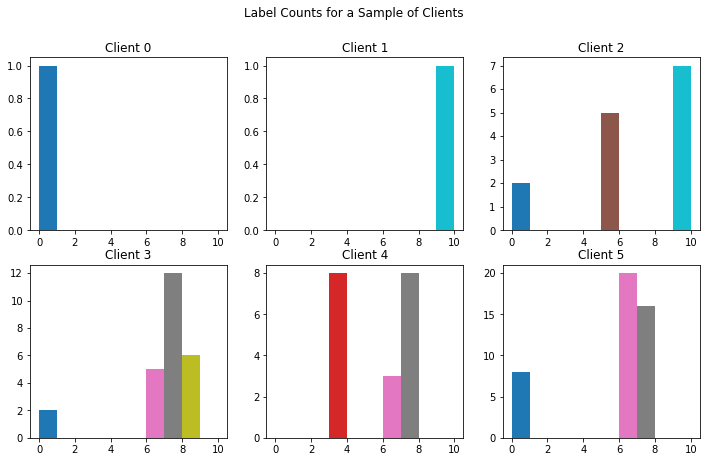

In [95]:
# Check distribution of Data among the 6 Clients 
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = cifar_train.create_tf_dataset_for_client(
      cifar_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0,1,2,3,4,5,6,7,8,9,10])


### Start Preprocessing the Data

In [96]:
#reshape to use with keras model
def reshape_cifar_element(element):
 """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
 x=tf.reshape(element['image'], [-1, 3072])
 x=tf.cast(x,dtype=tf.float32)
 x /= 255
 y=tf.reshape(element['coarse_label'], [-1, 1])
 return collections.OrderedDict( 
    x=(tf.cast(tf.reshape(element['image'], [-1, 3072]),dtype=tf.float32))/255,
    y=tf.reshape(element['label'], [-1, 1]))
        


In [97]:
# Build Federated preprocessing that will drive the client training
# load from the Inputted parameters 
def preprocess_dataset(dataset):
  return (dataset
          .shuffle(buffer_size=MAX_CLIENT_DATASET_SIZE)
          .repeat(CLIENT_EPOCHS_PER_ROUND)
          .batch(CLIENT_BATCH_SIZE, drop_remainder=False)
          .map(reshape_cifar_element)
          .prefetch(10))

In [98]:
# checks on examples data 
preprocessed_example_dataset = preprocess_dataset(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch


OrderedDict([('x',
              array([[0.80784315, 0.9607843 , 0.9764706 , ..., 0.28235295, 0.29411766,
                      0.20784314],
                     [0.58431375, 0.7882353 , 0.98039216, ..., 0.5568628 , 0.37254903,
                      0.24313726],
                     [0.27450982, 0.34509805, 0.08235294, ..., 0.44313726, 0.5019608 ,
                      0.19607843],
                     ...,
                     [0.2509804 , 0.2509804 , 0.2509804 , ..., 0.3254902 , 0.3254902 ,
                      0.3254902 ],
                     [0.7176471 , 0.7764706 , 0.8666667 , ..., 0.46666667, 0.47058824,
                      0.5058824 ],
                     [0.49411765, 0.54509807, 0.5529412 , ..., 0.59607846, 0.5058824 ,
                      0.4862745 ]], dtype=float32)),
             ('y',
              array([[71],
                     [49],
                     [93],
                     [71],
                     [33],
                     [29],
                     [71

In [99]:
#Function to iterate over clients and preprocess.
def make_federated_data(client_data, client_ids):
  return [
      preprocess_dataset(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [100]:
# Build Federated data as per the input parameters 
sample_clients = cifar_train.client_ids[0:NUMBER_OF_CLIENTS]

federated_train_data = make_federated_data(cifar_train, sample_clients)

print(f'Number of client datasets: {len(federated_train_data)}')
print(f'First dataset: {federated_train_data[0]}')

Number of client datasets: 2
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 3072)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int64)])>


### Keras Model Declaration

In [101]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(LeakyReLU(alpha=0.1))
BatchNormalization(axis=-1)
model.add(Conv2D(32, (3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

BatchNormalization(axis=-1)
model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU(alpha=0.1))
BatchNormalization(axis=-1)
model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

BatchNormalization()
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.1))
BatchNormalization()
model.add(Dropout(0.2))
model.add(Dense(100))


model.add(Activation('softmax'))


In [102]:
# Model=create_original_fedavg_cnn_model()
Model=model

In [103]:
Model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 12, 12, 64)       

In [104]:
# Wrap the keras Model to be used in TFF
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  return tff.learning.from_keras_model(
      Model,
      input_spec= preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]) 

### Custom Variable and Metric Configuration

In [105]:
# Declare custom variables and Model metrics 
# Trainable Variable : Weights and biases of CNN
# Model Metrics : Loss, Accuracy and number of examples to derive weighted average
cifar100Variables = collections.namedtuple('cifar100Variables','weights bias num_examples loss_sum accuracy_sum')

In [106]:
# function defines the variables and metrics 
def create_cifar100_variables():
    return cifar100Variables(
      weights=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(3072,100)),
          name='weights',
          trainable=True),
      bias=tf.Variable(
          lambda: tf.zeros(dtype=tf.float32, shape=(100)),
          name='bias',
          trainable=True),
      num_examples=tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum=tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum=tf.Variable(0.0, name='accuracy_sum', trainable=False)
    )

In [107]:
# Function to perform operation on Batch of Data
# Build Forward pass
def batch_model(variables,x):
    # since the last step in the keras model is Activation, we aply the same to the weights and biases
    return tf.nn.softmax(tf.matmul(x, variables.weights) + variables.bias)
  
# Define how forward pass will process metrics     
def cifar100_forward_pass(variables, batch):
  y = batch_model(variables, batch['x'])
  predictions = tf.cast(tf.argmax(y, 1), tf.int64)

  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(
      tf.reduce_sum(tf.one_hot(flat_labels, 100) * tf.math.log(y), axis=[1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))

  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  variables.num_examples.assign_add(num_examples)
  variables.loss_sum.assign_add(loss * num_examples)
  variables.accuracy_sum.assign_add(accuracy * num_examples)

  return loss, predictions

In [108]:
# Return metrics from each model
def get_local_unfinalized_metrics(variables):
  return collections.OrderedDict(
      num_examples=[variables.num_examples],
      loss=[variables.loss_sum, variables.num_examples],
      accuracy=[variables.accuracy_sum, variables.num_examples])

In [109]:
# Finalize metrics after training on all Clients 
def get_metric_finalizers():
  return collections.OrderedDict(
      num_examples=tf.function(func=lambda x: x[0]),
      loss=tf.function(func=lambda x: x[0] / x[1]),
      accuracy=tf.function(func=lambda x: x[0] / x[1]))

In [110]:
# Return Weighted Values
def get_local_cifar_metrics(variables):
  return collections.OrderedDict(
      num_examples=variables.num_examples,
      loss=variables.loss_sum / variables.num_examples,
      accuracy=variables.accuracy_sum / variables.num_examples)

In [111]:
# Aggregate Metrics across all clients 
@tff.federated_computation
def aggregate_cifar_metrics_across_clients(metrics):
  return collections.OrderedDict(
      num_examples=tff.federated_sum(metrics.num_examples),
      loss=tff.federated_mean(metrics.loss, metrics.num_examples),
      accuracy=tff.federated_mean(metrics.accuracy, metrics.num_examples))

### Customized Class declaration for TFF

In [112]:
from typing import Callable, List, OrderedDict

class cifar100Model(tff.learning.Model):

  def __init__(self):
    self._variables = create_cifar100_variables()

  @property
  def trainable_variables(self):
    return [self._variables.weights, self._variables.bias]

  @property
  def non_trainable_variables(self):
    return []

  @property
  def local_variables(self):
    return [
        self._variables.num_examples, self._variables.loss_sum,
        self._variables.accuracy_sum
    ]

  @property
  def input_spec(self):
    return collections.OrderedDict(
        x=tf.TensorSpec([None, 3072], tf.float32),
        y=tf.TensorSpec([None, 1], tf.int64))

  @tf.function
  def predict_on_batch(self, x, training=True):
    del training
    return batch_model(self._variables, x)
    
  @tf.function
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = cifar100_forward_pass(self._variables, batch)
    num_examples = tf.shape(batch['x'])[0]
    return tff.learning.BatchOutput(
        loss=loss, predictions=predictions, num_examples=num_examples)
        
  @tf.function
  def report_local_outputs(self):
    return get_local_cifar_metrics(self._variables)

  @property
  def federated_output_computation(self):
    return aggregate_cifar_metrics_across_clients


  @tf.function
  def report_local_unfinalized_metrics(
      self) -> OrderedDict[str, List[tf.Tensor]]:
    """Creates an `OrderedDict` of metric names to unfinalized values."""
    return get_local_unfinalized_metrics(self._variables)

  def metric_finalizers(
      self) -> OrderedDict[str, Callable[[List[tf.Tensor]], tf.Tensor]]:
    """Creates an `OrderedDict` of metric names to finalizers."""
    return get_metric_finalizers()

  @tf.function
  def reset_metrics(self):
    """Resets metrics variables to initial value."""
    for var in self.local_variables:
      var.assign(tf.zeros_like(var))

In [113]:
# training the model 
# no need for optimization on server as we are analyzing client learning
federated_averaging = tff.learning.build_federated_averaging_process(
    model_fn=cifar100Model,
    client_optimizer_fn= lambda: tf.keras.optimizers.Adam(learning_rate=0.001)
    # server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=5.0)
    # use_experimental_simulation_loop=True
    )

In [114]:
# Begin Tensorboard Initialization
import shutil
import datetime
run_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
hp = str
logdir = r"C:\Users\sidha\Stevens\AAI800 - Special Projects in AI\Project Execution\Tensorboard\TF-CNN3" + run_time + hyperparameters
if os.path.exists(logdir):
    shutil.rmtree(logdir)

summary_writer = tf.summary.create_file_writer(logdir)

### Start Iterative Process

In [115]:
state = federated_averaging.initialize()

In [116]:
with summary_writer.as_default():
    for round_num in range(0, NUMBER_OF_ROUNDS):
        state, metrics = federated_averaging.next(state, federated_train_data)
            # result = iterative_process.next(state, federated_train_data)
            # state = result.state
            # metrics = result.metrics
        print('round {:2d}, metrics={}'.format(round_num,metrics))
        for name, value in metrics['train'].items():
          tf.summary.scalar(name, value, step=round_num)
        summary_writer.flush()

round  0, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('num_examples', 200.0), ('loss', 3.939502), ('accuracy', 0.04)]))])
round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('num_examples', 200.0), ('loss', 3.6244953), ('accuracy', 0.08)]))])
round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('num_examples', 200.0), ('loss', 3.4307578), ('accuracy', 0.12)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('value_sum_process', ()), ('weight_sum_process', ())])), ('train', OrderedDict([('num_examples', 200.0), ('loss', 3.3220801), ('accuracy', 0.115)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([(

%##############################################


### Begin Evaluation on Test

In [117]:
#inspect the abstract type signature of the evaluation function
evaluation = tff.learning.build_federated_evaluation(cifar100Model)
print(evaluation.type_signature.formatted_representation())

(<
  server_model_weights=<
    trainable=<
      float32[3072,100],
      float32[100]
    >,
    non_trainable=<>
  >@SERVER,
  federated_dataset={<
    x=float32[?,3072],
    y=int64[?,1]
  >*}@CLIENTS
> -> <
  num_examples=float32@SERVER,
  loss=float32@SERVER,
  accuracy=float32@SERVER
>)


In [118]:
# Pull final Model wights from training 
model_weights = tff.learning.ModelWeights(trainable=state.model,non_trainable=state.model)
type(model_weights)

tensorflow_federated.python.learning.model_utils.ModelWeights

In [119]:
#Weight Description
model_weights

ModelWeights(trainable=ModelWeights(trainable=[array([[-0.01774468, -0.01918945, -0.01918945, ..., -0.01918945,
        -0.01918945, -0.01679161],
       [-0.01733185, -0.02059056, -0.02059056, ..., -0.02059056,
        -0.02059056, -0.01706184],
       [-0.01696984, -0.01977619, -0.01977619, ..., -0.0197762 ,
        -0.0197762 , -0.01728554],
       ...,
       [-0.01874358, -0.02141564, -0.02141564, ..., -0.02141563,
        -0.02141563, -0.01679137],
       [-0.01881838, -0.02167221, -0.02167221, ..., -0.02167221,
        -0.02167221, -0.01693343],
       [-0.01859659, -0.02080034, -0.02080034, ..., -0.02080034,
        -0.02080034, -0.0168134 ]], dtype=float32), array([-0.02047424, -0.03095972, -0.03095972, -0.03095972, -0.03095972,
       -0.03095972, -0.03095972, -0.03095972, -0.03095972, -0.02162179,
       -0.01232217, -0.03095972, -0.03095972, -0.03095972, -0.03095972,
       -0.02275319, -0.01581776, -0.03095972, -0.03095972, -0.03095972,
       -0.03095972, -0.02316058, -0.

In [120]:
# Applying Model Evaluation Test Data 
train_metrics = evaluation(model_weights.trainable, federated_train_data)
str(train_metrics)

"OrderedDict([('num_examples', 200.0), ('loss', 3.3205395), ('accuracy', 0.155)])"